In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle


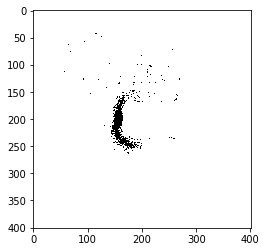

In [2]:
data_raw = np.fromfile('alg_test/data1.dat')
data = data_raw.reshape((401, 401))
# plot data
plt.imshow(np.flipud(data), cmap='gray_r')

# Clustering

In [3]:
from dbscan import distance, DBSCAN

In [4]:
x, y = np.where(data==1.0) # get x, y coordinate from raw input
data_tofit = np.stack([x, y], axis=1).astype(np.float) # data to fit in DBSCAN model

# Calculate pair-wise distance, time-consuming
LOAD = False

if LOAD:
    with open("distance.pkl", "rb") as f:
        dist = pickle.load(f)
else:
    dist = distance(data_tofit)
    pickle.dump(dist, open("distance.pkl", 'wb'))



In [5]:
# Fit model and get labels
model = DBSCAN(eps=10, MinPts=4)
labels = model.fit(data_tofit)

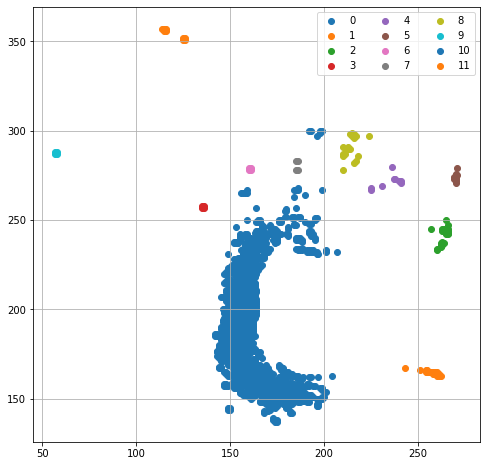

In [6]:
# Visualize clustering
plt.figure(0, figsize=[8,8])
for group in np.unique(labels):
    if group != -1:
        idx = np.where(labels == group)
        plt.scatter(data_tofit[:, 1][idx], data_tofit[:, 0][idx], label = group)

plt.legend(loc=1, ncol=3)
plt.grid()
plt.show()


**Get indices of points in class 0 which is the biggest cluster. It will be used in the following sections**

In [7]:
data_index = np.where(np.array(labels)==0)[0]

# Find boundary points

### Use Delaunay triangle and get alpha shape(concave hull)

**After some research, I found this algorithm is a good approach for this problem**

In [8]:
from findshape import alpha_shape, find_boundary
from util import plot_bd_dbscan, plot_boundary

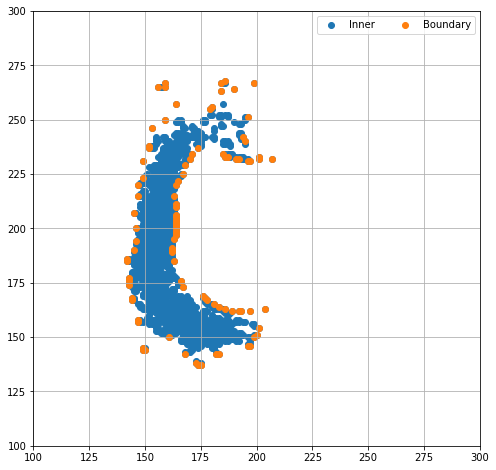

In [9]:
# image frame to Cartesian frame
points = np.fliplr(data_tofit[data_index, :]) 
# candidate polygon object, need to find its boundary
concave_hull = alpha_shape(points, alpha=8) 
# Extract coordinates from polygon object
pt_bound = np.array(list(concave_hull.array_interface_base["data"])).reshape(-1,2) 
# Visualize
plot_boundary(pt_bound, data_tofit, data_index)

### Find boundary points using DBSCAN model

**This method is the first comming to my mind, since DBSCAN has a model that can find boundary point and noise
point. However, it either find a tight boundary and treat many sparse area as noise, or it cannot find a complete 
boundary. This is because at boundary the density is high, hard to tell it is a core or boundary point.**

**Performance comparison with different parameters. Very sensitive to parameters.**

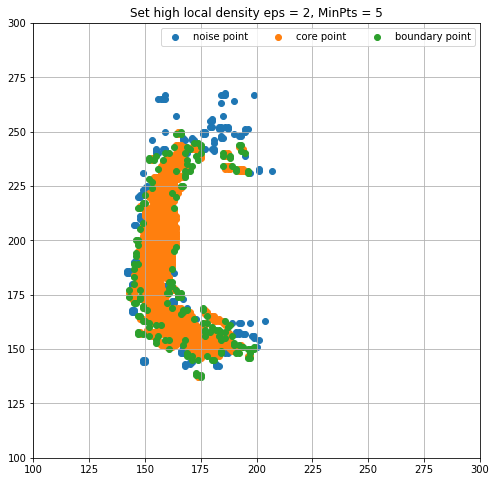

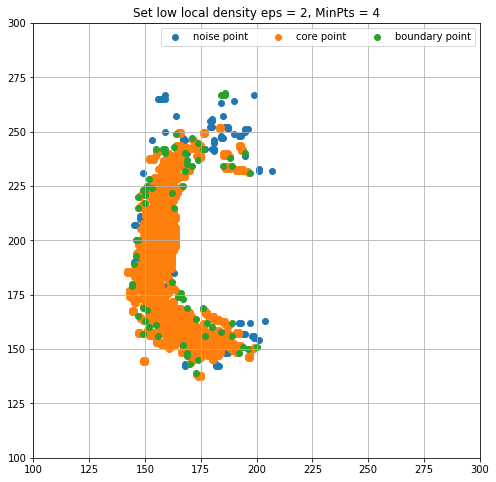

In [10]:
plt.figure(1, figsize=[8,8])
plt.title("Set high local density eps = 2, MinPts = 5")
point_type = find_boundary(dist, data_index, eps=2, MinPts=5)
_ = plot_bd_dbscan(point_type, data_tofit)

plt.figure(2, figsize=[8,8])
plt.title("Set low local density eps = 2, MinPts = 4")
point_type = find_boundary(dist, data_index, eps=2, MinPts=4)
_ = plot_bd_dbscan(point_type, data_tofit)

# Extract line segments from boundary points

In [11]:
from findbound import extract_lines,fit_line

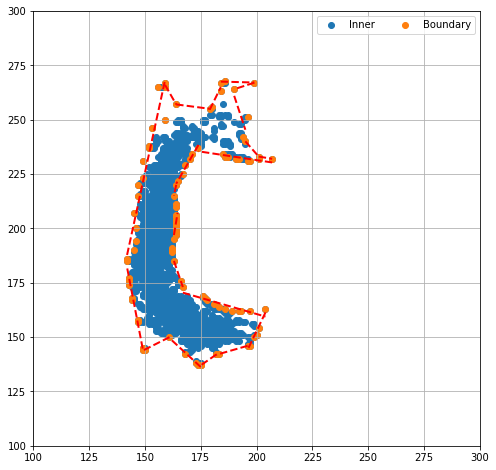

In [12]:
line_func = extract_lines(pt_bound, idx_s=0, idx_t=len(pt_bound)-1, threshold=4)
plot_boundary(pt_bound, data_tofit, data_index, line_func=line_func)